<a href="https://colab.research.google.com/github/umeshrawat/MachineLearning/blob/master/Unsupervised_Classification/SocialClusters/src/SocialClustersPyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The raw data set is a list of edges between nodes. The notebook loads data sets from the github repository, conducts Feature Engineering, Models the data and features using classification algorithms, evaluates their performance and concludes by summarizing the results of the modelling techniques.

Full Name: Umesh Rawat

Email Address: umeshrawat@gmail.com

Problem Statement: ClusterQuest: Unveiling Cohorts in Social Networks.

**Stage 1: Objective and Solution definition:**

Distribute the dataset containing list of edges between users (nodes) into meaningful clusters based on the node characterstics. The following solution creates clusters based on:
1. Number of node's immediate neighbors (Direct connections): Nodes with large number of immediate neighbors (Degree = 1) are good candidates for being centroids of clusters. The solution calculates degrees of each node, finds the mean and creates clusters around nodes that have degrees higher than mean value.
This information helps in "Community Engagement" objective.

2. Number of well-connected nodes: Node's Eigen vector centrality provides this informaion. Solution calculates each node's Eigen Vector centrality measure, clusters based on nodes above mean value. This helps in "Influencer Identification" business objective.

3. Number of node's Closeness measure on 3 hops: This helps in "Community Engagement". Users with higher values help in larger coverage and quick engagements with large set of users thus helping in "Community Engagement".

4. "Networking Users": Users that are the bridges between clusters.
These are users with ZERO clustering coefficients or High Betweenness Centrality measure.
Crucial for information flow across clusters, fulfills the "Audience Segmentation" business objective.

**Stage 2: Data Collection and Reading:**

In [2]:
!git clone https://github.com/umeshrawat/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 499, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 499 (delta 104), reused 262 (delta 91), pack-reused 208
Receiving objects: 100% (499/499), 20.99 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [3]:
# set the root path of the dataset.
root_folder_path = '/content/MachineLearning/Unsupervised_Classification/SocialClusters/Dataset/facebook_combined.txt'

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.

In [ ]:
# check installed version
import pycaret
pycaret.__version__

'3.3.2'

In [4]:
# Load the raw dataset into a Graph object.
import networkx as nx

nx_graph = nx.read_edgelist(root_folder_path, create_using = nx.Graph(), nodetype = int)


**Stage 3: Exploratory Data Analysis and Feature Engineering.**

Let's find out if there are any self-joint nodes?

In [ ]:
!pip install python-igraph

In [ ]:
import igraph as ig

# Count the number of self-loop edges in NetworkX
num_self_joints = sum(1 for u, v in nx_graph.edges() if u == v)

print(num_self_joints)

0


--> No self-joint (self-directed) nodes in the data set. That is, each node is connected to at least another node at the minimum.

Next, Let's calculate the Degree and Cluster Coefficient centrality measures.

In [5]:
import pandas as pd

# Calculate node features
degree_centrality = nx.degree_centrality(nx_graph)
clustering_coefficient = nx.clustering(nx_graph)
eigenVector_centrality = nx.eigenvector_centrality(nx_graph)
# Create DataFrame
df_nodes = pd.DataFrame({
    'Node': list(nx_graph.nodes()),
    'Degree_Centrality': [degree_centrality[node] for node in nx_graph.nodes()],
    'Clustering_Coefficient': [clustering_coefficient[node] for node in nx_graph.nodes()],
    'EigenVector_Centrality': [eigenVector_centrality[node] for node in nx_graph.nodes()]
    # Add other node features as needed
})

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
print(df_nodes.describe())

            Node  Degree_Centrality  Clustering_Coefficient  \
count 4039.00000         4039.00000              4039.00000   
mean  2019.00000            0.01082                 0.60555   
std   1166.10320            0.01298                 0.21446   
min      0.00000            0.00025                 0.00000   
25%   1009.50000            0.00272                 0.46667   
50%   2019.00000            0.00619                 0.60000   
75%   3028.50000            0.01412                 0.75238   
max   4038.00000            0.25879                 1.00000   

       EigenVector_Centrality  
count              4039.00000  
mean                  0.00386  
std                   0.01525  
min                   0.00000  
25%                   0.00000  
50%                   0.00000  
75%                   0.00003  
max                   0.09541  


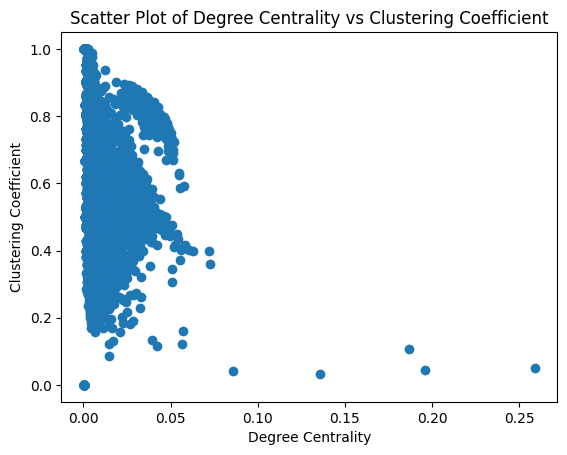

In [6]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(degree_centrality.values(), clustering_coefficient.values())
plt.xlabel('Degree Centrality')
plt.ylabel('Clustering Coefficient')
plt.title('Scatter Plot of Degree Centrality vs Clustering Coefficient')
plt.show()

In [9]:
# Group by degree and clustering coefficient and count nodes
node_counts = df_nodes.groupby(['Degree_Centrality', 'Clustering_Coefficient'])['Node'].count().reset_index(name='Count').sort_values('Degree_Centrality', ascending=False)

print(node_counts)

      Degree_Centrality  Clustering_Coefficient  Count
2782  0.258791480931154       0.049038479165521      1
2781  0.196136701337296       0.044774546986936      1
2780  0.186973749380882       0.105485973264005      1
2779  0.135463100544824       0.032230414314509      1
2778  0.085933630510154       0.041961653145875      1
2777  0.072808320950966       0.359917345777902      1
2776  0.072065378900446       0.399644507643086      1
2775  0.062902426944032       0.399676325044350      1
2774  0.060673600792472       0.402040816326531      1
2773  0.058197127290738       0.416512093107838      1
2772  0.057949479940565       0.593301786434834      1
2771  0.057949479940565       0.411576978100583      1
2770  0.057206537890045       0.161641257293431      1
2769  0.056711243189698       0.123036849766337      1
2768  0.055968301139178       0.401376597836775      1
2767  0.055473006438831       0.587363869314542      1
2766  0.055225359088658       0.370581343675514      1
2765  0.05

**INTERPRETATION:**

Above measure values and plot shows that:
1. With average Cluster Coefficient value of 0.61, it shows that the clusters have "Close neighbors" or in other words, there is close integration between neighbors.
2. There is only 1 user in the network who has 0.26 as Degree measure. Low Degree centrality shows that the network doesn't contain users that are centroids of large clusters. Potentially, this network contains clusters with users with high degrees within each of those sub-clusters.
3. Overall, the users have close relationships with their immediate neighbors but not highly connected to every other user.

Let's cross validate this observation as a graph plot:

In [ ]:
import matplotlib.pyplot as plt

def plot_centrality_distribution(centrality_data: dict, centrality_name: str):
  plt.figure(figsize=(10, 6))
  pos = nx.spring_layout(nx_graph)  # Choose a layout for the graph
  node_sizes = [centrality_data[node] * 100 for node in nx_graph.nodes()]
  # Draw the graph with node sizes and labels
  plt.figure(figsize=(10, 10))  # Adjust figure size as needed
  nx.draw_networkx_nodes(nx_graph, pos, node_size=node_sizes, node_color='red')
  nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
  nx.draw_networkx_labels(nx_graph, pos, font_size=10, font_color='blue')

  plt.title("Graph Visualization: " + centrality_name )
  plt.axis('off')  # Turn off axis
  plt.show()

<Figure size 1000x600 with 0 Axes>

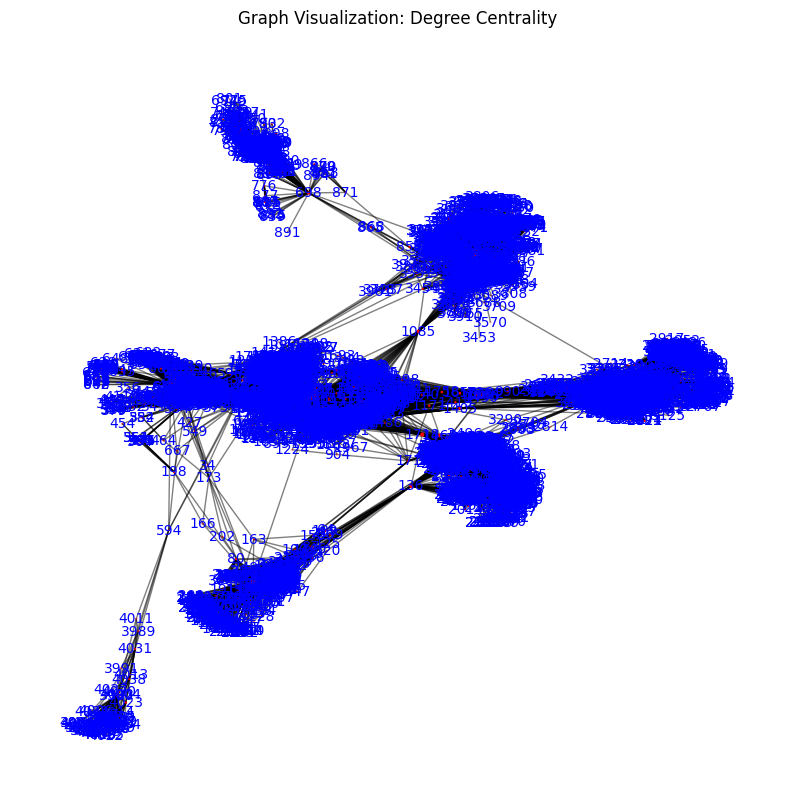

<Figure size 1000x600 with 0 Axes>

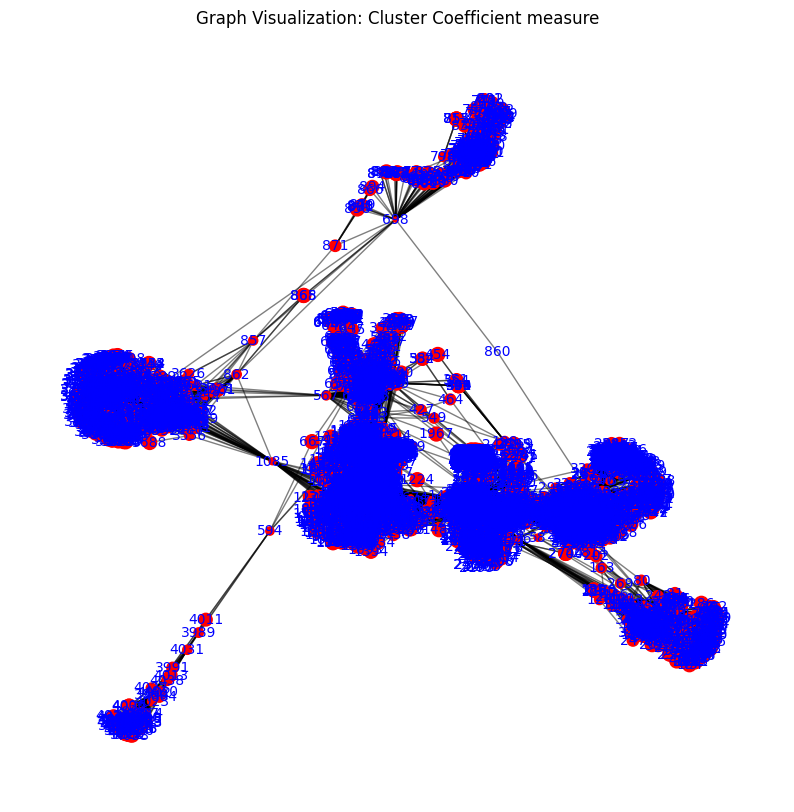

In [ ]:
#Plot Centrality measures
plot_centrality_distribution(degree_centrality, "Degree Centrality")
plot_centrality_distribution(clustering_coefficient, "Cluster Coefficient measure")

These two visualizations corroborate the observations:
1. In general, users aren't connected to all other users. They are part of sub clusters of users based on their immediate neighbors and closeness of their connections.
2. Connections are strong - Immediate neighbors are close to each other.
3. Based on degree of connections, network can be divided into 7 clusters, and into 6 clusters based solely on the Cluster coefficient measure.

Next, We will find out classification algorithms that effectively models the clustering based on these 2 measures.

**Stage 2: Modelling.**

We will model using:
1. K-Means.
2. Node2vec
3. Hierarchical.
4. DBScan.

Modelling #1: K-Means

In [12]:
from sklearn.cluster import KMeans

socialClusterDataFrame = df_nodes[['Degree_Centrality', 'Clustering_Coefficient']]

# Initialize the KMeans model with the desired number of clusters  = 7
kmeans = KMeans(n_clusters=7, random_state=42)

# Fit the model to your data
kmeans.fit(socialClusterDataFrame)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Add the cluster labels to your dataframe
socialClusterDataFrame['cluster'] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-12-093d2f15900d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socialClusterDataFrame['cluster'] = labels


In [13]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
socialClusterDataFrame.groupby('cluster').describe()

Degree_Centrality                                                  \
                    count    mean     std     min     25%     50%     75%   
cluster                                                                     
0               943.00000 0.01229 0.01043 0.00099 0.00421 0.00867 0.01795   
1               635.00000 0.01403 0.01586 0.00099 0.00272 0.00520 0.02402   
2               390.00000 0.01035 0.00834 0.00149 0.00471 0.00780 0.01337   
3               817.00000 0.01006 0.01011 0.00074 0.00322 0.00619 0.01362   
4               459.00000 0.00198 0.00258 0.00050 0.00074 0.00124 0.00223   
5               708.00000 0.01267 0.01172 0.00124 0.00471 0.00892 0.01610   
6                87.00000 0.01226 0.04318 0.00025 0.00025 0.00025 0.00025   

                Clustering_Coefficient                                  \
            max                  count    mean     std     min     25%   
cluster                                                                  
0       0.05795              943.00000 0.55085 0.03395 0.49351 0.52381   
1       0.05002              635.00000 0.80336 0.03910 0.73672 0.76923   
2       0.07281              390.00000 0.29703 0.05093 0.15630 0.26587   
3       0.05498              817.00000 0.66863 0.03564 0.61000 0.63772   
4       0.02798              459.00000 0.96913 0.04055 0.88843 0.93333   
5       0.07207              708.00000 0.43543 0.03469 0.36615 0.40875   
6       0.25879               87.00000 0.01131 0.03288 0.00000 0.00000   

                                 
            50%     75%     max  
cluster                          
0       0.54971 0.58049 0.60983  
1       0.80000 0.83333 0.88462  
2       0.30560 0.33701 0.36575  
3       0.66667 0.69799 0.73626  
4       1.00000 1.00000 1.00000  
5       0.43598 0.46667 0.49311  
6       0.00000 0.00000 0.13518

**Interpretation:**

For the entire graph,
The mean Degree centrality measure is: 0.01082,
mean Cluster Coefficient is:           0.60555

1. Clusters 0,1,5,6 contains average degree greater than the network's mean.
These clusters comprise of 2373 users.

2. Clusters 2,3,4 contain the remaining number of users with low average degree.
These clusters have 1666 users.

3. Clusters 1,3,4 have mean Cluster Coefficient higher than network's average.

4. Clusters 0,2,5,6 have mean Cluster Coefficient lower than network's average.

Cluster 1 contains 635 users: High degree of neighbors, High closeness with neighbors.
Cluster 0 contains 943 users: High degree of neighbors, Low closeness with neighbors.
Cluster 2 contains 390 users: Low degree of neighbors, Low in closeness with neighbors.
Cluster 3 contains 817 users: Low degree of neighbors, High in closeness with neighbors.
Cluster 4 contains 459 users: Low degree of neighbors, Highest in closeness with Neighbors.
Cluster 5 contains 708 users: High degree of neighbors, Low in closeness with Neighbors.
Cluster 6 contains 87 users: Low degree of neighbors, Low in closeness.

2 Groups can be formed from above observations:

**Group A**: Users base within Tightly-Knit local cluster.

Contains 4 Clusters: 0, 1, 3, 4.

Total number of users: 2854.

**Group B**: Remaining users with low "closeness".

Contains 3 Clusters: 2,5,6.

Total numbers of Users: 1185

Let's find out:

1. Elbow plot - To know how many clusters are appropriate for the graph data. The value from which the rate of change of inertia slows down significantly, is the optimal number of clusters.
2. Silhouette Score - To know how well seperated each node is from its own cluster compared to other clusters. Range of score from -1, 0, 1 where -1 indicates incorrect clustering, 0 indicates that the node is close to the boundary between two clusters, and close to 1 indicates that the node is well-seperated from other clusters.
3. Calinski-Harabasz Score - Score based on the ratio of of between-cluster dispersion to within-cluster dispersion. A higher score indicates better-defined and separated clusters.
4. Davies-Bouldin Score - Measures the average similarity between each cluster and its most similar cluster. A lower score suggestss that the clusters are more compact and well-seperated.

for k values in the range 2 to 10.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 2, Inertia: 4.2546225655561205, Silhouette Score: 0.4527894425002836, Calinski-Harabasz score: 3019.8735828522044, Davies-Bouldin score: 0.8925297240545382


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 3, Inertia: 2.9627572369876276, Silhouette Score: 0.5069754024236856, Calinski-Harabasz score: 3047.7019646869207, Davies-Bouldin score: 0.7961014019082638


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 4, Inertia: 1.9132261420108816, Silhouette Score: 0.5830217171575515, Calinski-Harabasz score: 3883.420618390792, Davies-Bouldin score: 0.5974552832011419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 5, Inertia: 1.3676845330188512, Silhouette Score: 0.5875822023646462, Calinski-Harabasz score: 4475.5891693759595, Davies-Bouldin score: 0.5395405631703493


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 6, Inertia: 0.8566158537635098, Silhouette Score: 0.5809744836028363, Calinski-Harabasz score: 6196.440702511238, Davies-Bouldin score: 0.506371153663217


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 7, Inertia: 0.6777995089436718, Silhouette Score: 0.6099166332241834, Calinski-Harabasz score: 6701.653838541403, Davies-Bouldin score: 0.48185697232317926


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 8, Inertia: 0.5629285559771792, Silhouette Score: 0.6050466995882615, Calinski-Harabasz score: 7032.239469377551, Davies-Bouldin score: 0.604676646349556


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 9, Inertia: 0.4849093526729962, Silhouette Score: 0.6010386178598746, Calinski-Harabasz score: 7222.505027204493, Davies-Bouldin score: 0.6186966455914691


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 10, Inertia: 0.4157863385590165, Silhouette Score: 0.6049973014458121, Calinski-Harabasz score: 7559.936555617647, Davies-Bouldin score: 0.6046075708372436


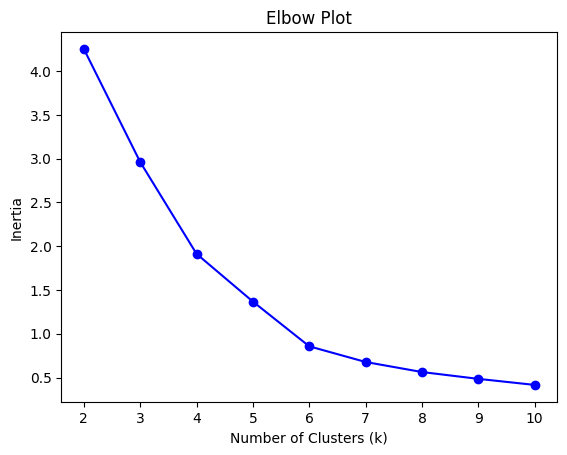

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

X = socialClusterDataFrame[['Degree Centrality', 'Eigen Vector Centrality', 'Closeness Centrality', 'Betweenness Centrality']]

inertias = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
for k in range(2, 11):  # Check for k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # Calculate the Silhouette Score
    silhouette_scores.append(silhouette_score(X, labels))
    # Calculate the Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(X, labels))
    # Calculate the Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(X, labels))

    print(f"K: {k}, Inertia: {kmeans.inertia_}, Silhouette Score: {silhouette_score(X, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(X, labels)}, Davies-Bouldin score: {davies_bouldin_score(X, labels)}")

plt.plot(range(2, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

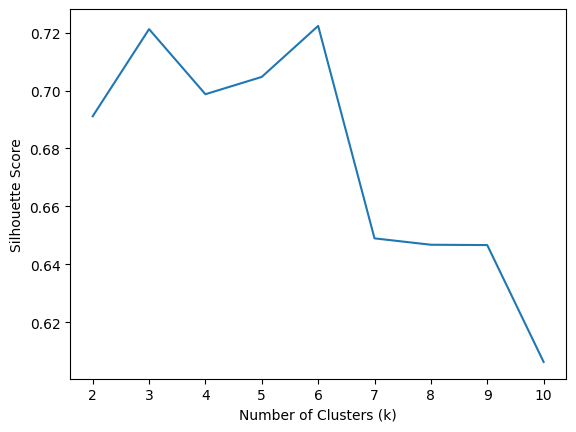

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

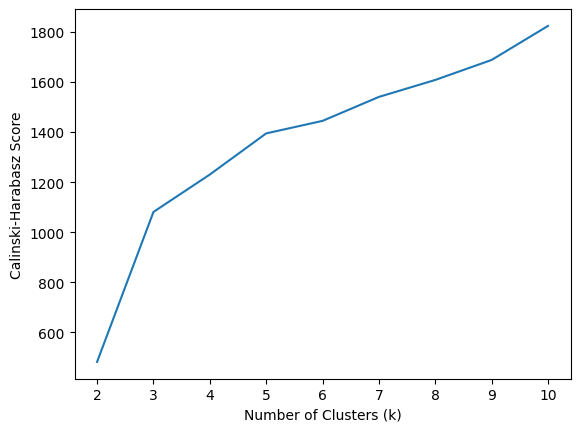

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

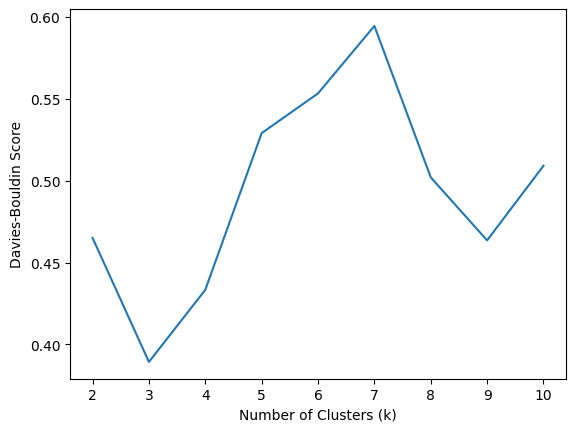

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

From above calculations and plotting, K = 2 shows the maximum difference in terms of inertia.
Hence taking K = 2 for clustering. Silhouette Score = 0.45 which indicates that the 2 clustes are neither dense nor overlapping.

For k = 4, Inertia value is high, silhouette score is low.
For k = 6, Inertia value reduces, silhouette score decreases.
For k = 7, Inertia value is low, silhouette score is the highest.
**The above graphical visualizations and score values indicates that 6 is the optimal value of clusters for this graph data.**

**This is also supported by the two graphical visualizations of Nodes against Degress Centrality and the EigenVector Centrality.**

**Modelling #2: Node2vec**

Next, Let's use Node2vec algorithm to analyse this data set and deduce graph clustering.

In [ ]:
#Code to calculate node2vec algorithm on this graph data
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.

In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(nx_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Learn embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get node embeddings
embeddings = model.wv

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

In [ ]:
# Perform K-means clustering -
kmeans = KMeans(n_clusters=6, random_state=0, n_init='auto').fit(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 2, Inertia: 29835.015625, Silhouette Score: 0.1188376247882843, Calinski-Harabasz score: 543.1309561679163, Davies-Bouldin score: 2.4620834693533227


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 3, Inertia: 26566.76171875, Silhouette Score: 0.16327126324176788, Calinski-Harabasz score: 553.154067891339, Davies-Bouldin score: 2.2405392718473554


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 4, Inertia: 23255.828125, Silhouette Score: 0.21424460411071777, Calinski-Harabasz score: 612.6565725166907, Davies-Bouldin score: 1.9934566329075227


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 5, Inertia: 20898.912109375, Silhouette Score: 0.25085705518722534, Calinski-Harabasz score: 624.9207682420937, Davies-Bouldin score: 1.816248927292157


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 6, Inertia: 19134.59375, Silhouette Score: 0.2780138850212097, Calinski-Harabasz score: 620.2719156694942, Davies-Bouldin score: 1.504321837973782


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 7, Inertia: 17574.31640625, Silhouette Score: 0.28269290924072266, Calinski-Harabasz score: 622.3057499237126, Davies-Bouldin score: 1.484420369736728


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 8, Inertia: 16794.642578125, Silhouette Score: 0.2596818506717682, Calinski-Harabasz score: 584.7627150940917, Davies-Bouldin score: 1.594727430687191


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 9, Inertia: 16100.16015625, Silhouette Score: 0.24875521659851074, Calinski-Harabasz score: 555.3354392009928, Davies-Bouldin score: 1.628548295694606


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 10, Inertia: 15526.876953125, Silhouette Score: 0.23712323606014252, Calinski-Harabasz score: 528.2586112619772, Davies-Bouldin score: 1.6612069839483028


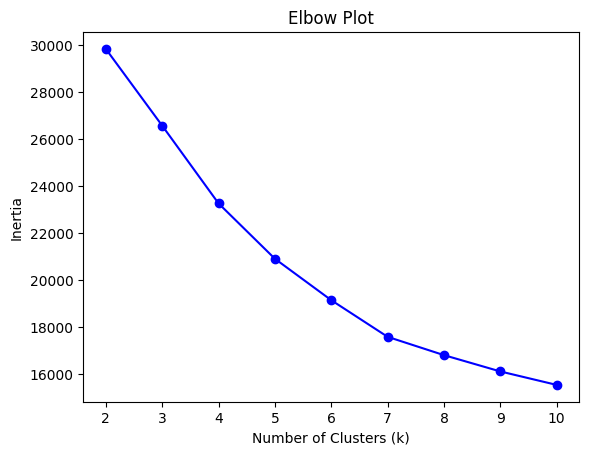

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertias = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Convert KeyedVectors to a NumPy array
embedding_array = embeddings.vectors

for k in range(2, 11):  # Check for k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embedding_array)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # Calculate the Silhouette Score
    silhouette_scores.append(silhouette_score(embedding_array, labels))
    # Calculate the Calinski-Harabasz Score
    calinski_harabasz_scores.append(calinski_harabasz_score(embedding_array, labels))
    # Calculate the Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(embedding_array, labels))

    print(f"K: {k}, Inertia: {kmeans.inertia_}, Silhouette Score: {silhouette_score(embedding_array, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(embedding_array, labels)}, Davies-Bouldin score: {davies_bouldin_score(embedding_array, labels)}")

plt.plot(range(2, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

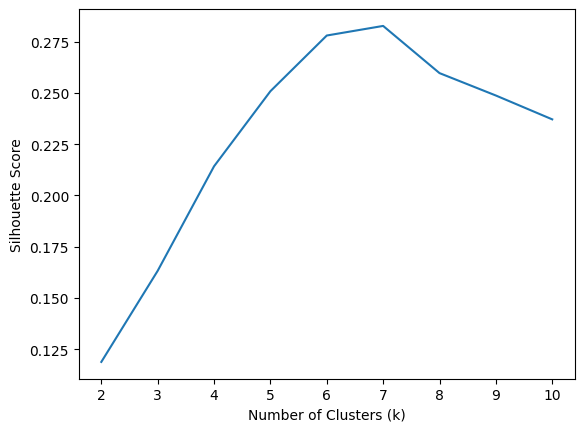

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

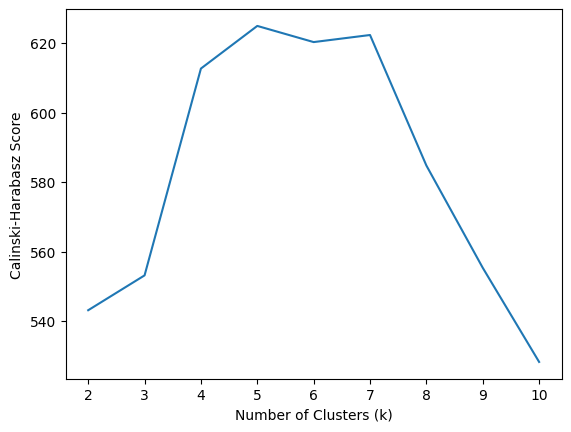

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

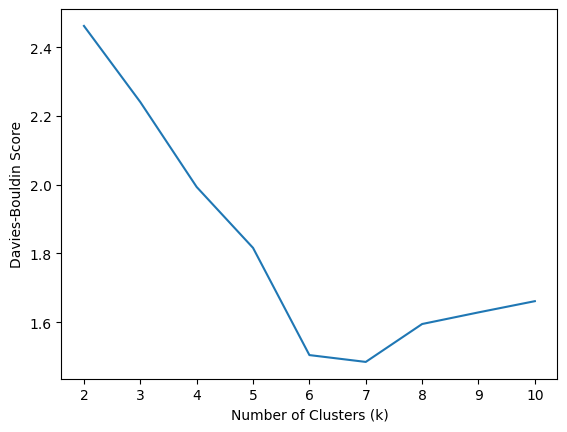

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

--> Node2vec algorithm shows 7 being the optimal number of clusters.

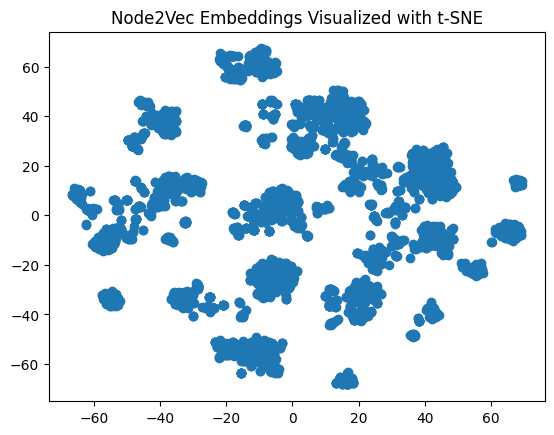

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np # Import numpy for array manipulation

nodes = list(embeddings.key_to_index.keys())
embedding_values = [embeddings[node] for node in nodes]

# Convert list of arrays to a 2D numpy array
embedding_values = np.array(embedding_values)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embedding_values)

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title('Node2Vec Embeddings Visualized with t-SNE')
plt.show()

Modelling #3: Hierarchical Algorithm

In [ ]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform

# Compute shortest path distances between all pairs of nodes
distances = squareform(pdist(nx.to_numpy_array(nx_graph)))

<ipython-input-19-b3bf8e236552>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distances, method='ward')


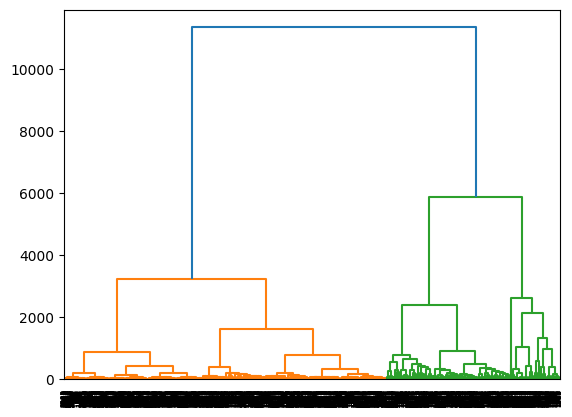

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(distances, method='ward')

# Plot the dendrogram
plt.figure()
dendrogram(Z)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

# Convert KeyedVectors to a NumPy array
embedding_array = embeddings.vectors

# Hierarchical clustering
# Cut the dendrogram to obtain 6 clusters
clusters = fcluster(Z, k, criterion='maxclust')


# Calculate the Silhouette Score
silhouette_scores.append(silhouette_score(distances, clusters))
# Calculate the Calinski-Harabasz Score
calinski_harabasz_scores.append(calinski_harabasz_score(distances, clusters))
# Calculate the Davies-Bouldin Score
davies_bouldin_scores.append(davies_bouldin_score(distances, clusters))

print(f"K: {k}, Silhouette Score: {silhouette_score(distances, clusters)}, Calinski-Harabasz score: {calinski_harabasz_score(distances, clusters)}, Davies-Bouldin score: {davies_bouldin_score(distances, clusters)}")


K: 10, Silhouette Score: 0.3848016164040423, Calinski-Harabasz score: 7386.9683589518545, Davies-Bouldin score: 0.8071325210636466


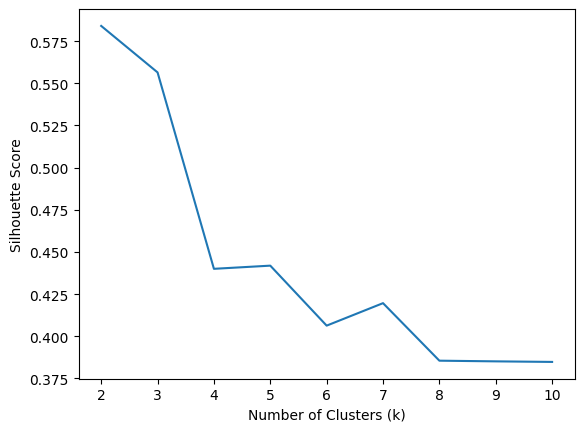

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

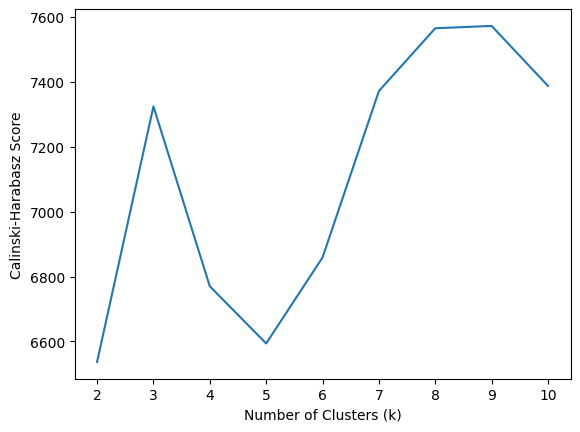

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), calinski_harabasz_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

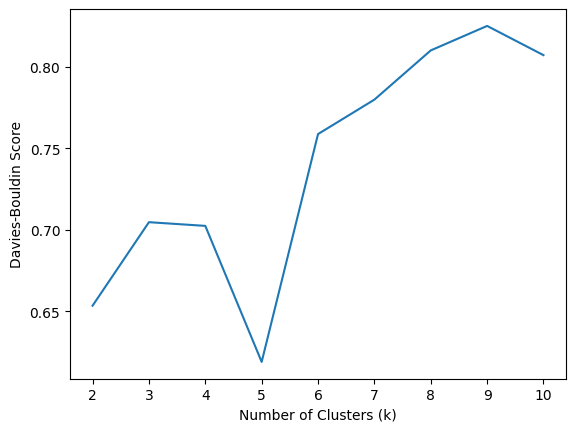

In [ ]:
# Plot the scores to find the optimal k
import matplotlib.pyplot as plt
plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.show()

Modelling #4: DBSCAN Algorithm.


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Adjust eps and min_samples to potentially find more clusters
clustering = DBSCAN(eps=10, min_samples=5).fit(embedding_array)

labels = clustering.labels_

# Check the number of unique labels (excluding noise, if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters >= 2:
    score = silhouette_score(embedding_array, labels)
    print("Silhouette Score:", score)
else:
    print("Not enough clusters to calculate Silhouette Score.")

Not enough clusters to calculate Silhouette Score.


Employing additional clustering algorithms:

1. Mean-Shift Clustering.
2. Spectral Clustering.
3. Affinity Propagation.
4. OPTICS.



In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MeanShift

#Mean-shift clustering

# Extract node embeddings.
embeddings_for_additional_algo = nx.spring_layout(nx_graph)

# Convert KeyedVectors to a NumPy array
embedding_array = np.array(list(embeddings_for_additional_algo.values()))
# Apply MeanShift clustering
clustering = MeanShift().fit(embedding_array)

# Get the cluster labels
labels = clustering.labels_

print(f"Silhouette Score: {silhouette_score(embedding_array, labels)}, Calinski-Harabasz score: {calinski_harabasz_score(embedding_array, labels)}, Davies-Bouldin score: {davies_bouldin_score(embedding_array, labels)}")


Silhouette Score: 0.5049376784124221, Calinski-Harabasz score: 3371.3053969725206, Davies-Bouldin score: 0.6364849577365619


In [ ]:
num_clusters = len(clustering.cluster_centers_)
print("Number of clusters:", num_clusters)

Number of clusters: 2
